## Basket option pricing with neural network and Monte Carlo solver
The goal of this project is to build an artifical neural network to price European basket options. For brevity, I limited this analysis to call options. 

This is a proof-of-concept of an accelerated options pricing model. Therefore, I used simulated data to train the network. Ju's 2002 method using Taylor series expansion was used to generate simulated basket option prices. Ju's approximation accounts for the basket's volatility structure through a Taylor expansion, and it simplifies the evaluation of basket options while assuming homogenous volatility among the underlying assets. To realize the advantages of a neural network approach in a real-world setting--which could include accurately modelling behaviour that violates Black-Scholes--we would want to collect a large dataset of historical option prices. Without training on historical data, the limitations of the neural network model will almost certainly be the same as the limitations of Levy's formula.

This analysis is organized as follows:
1. Simulate approximate prices of 10,000 European basket options using Ju's Taylor series approximation.
1. Train a fully-connected artifical neural network to estimate option prices.
1. For a subset of the testing data, compare option prices from the neural network model with those from a Monte Carlo solver.


In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import time as t
import pandas as pd

from src.simulation import SimulateBasketPrices
from src.nn_train import PricingNetwork
from src.options import BasketOption

In [2]:
sns.set_style('whitegrid')

In [3]:
tf.random.set_seed(321)
np.random.seed(123)

#### 1. Simulate approximate prices with Levy's formula

In [4]:
# Average price of the simulated assets. The 
# simulator will add normal noise to all simulated assets. 
prices = np.ones(4)*100.
# Average volatility of simulated assets. The simulator
# will add a small uniform random on [-0.025,0.025).
vol = 0.4
# For each simulated basket, the underlying assets have the 
# same correlation structure.
corr = np.array([[1.,0.5,0.5,0.5],
                 [0.5,1.,0.5,0.5],
                 [0.5,0.5,1.,0.5],
                 [0.5,0.5,0.5,1.]])

In [5]:
# Simulate 10,000 baskets, each with 4 underlying assets 
simulator = SimulateBasketPrices(4, n_prices=10000)
 
# The simulation routine uses the BasketOption class defined in options.py
simulated_prices = simulator.simulate_prices(prices, vol, corr, method="ju_taylor")
# simulated_prices = simulator.simulate_prices(prices, vol, corr)

#### 2. Train a neural network model to estimate option prices

In [6]:
train_prices = simulated_prices.sample(frac=0.8, random_state=123)
test_prices = simulated_prices.drop(train_prices.index)

X_train, X_test = simulated_prices.sample(frac=0.8), simulated_prices.drop(train_prices.index)
y_train, y_test = X_train.pop('Basket_Price'), X_test.pop('Basket_Price')

X_train, X_test = train_prices.copy(), test_prices.copy()
y_train, y_test = X_train.pop('Basket_Price'), X_test.pop('Basket_Price')

X_train = X_train.to_numpy() if isinstance(X_train, pd.DataFrame) else X_train
X_test = X_test.to_numpy() if isinstance(X_test, pd.DataFrame) else X_test


In [7]:
# The PricingNetwork class has the model build, compilation, and
# testing functionality.
pricer = PricingNetwork((X_train, y_train), (X_test, y_test))


C:\Users\Vlada\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


The model has 4+2(N_assets) input features:
* N features for the price of each asset
* N features for the weight of each asset in the basket
* Strike price
* Maturity date
* Volatility (all assets have equal volatility for Ju's Taylor approximation)
* Risk-free interest rate (set to zero for simplicity)

The model architecture is inspired by Ke & Yang 2019 (capstone project for Stanford CS230). They found a 4-layer network with ReLU activations and batch normalization to work well. Therefore, the network I implement here has three layers with 256 nodes each and a final layer with a single node. The first three layers are followed by batch norm. I also chose to normalize the features before passing into the neural network.

Throughout training, the validation loss was lower than the training loss. This could be a quirk of the random train/test split and isn't terribly concerning for this simulated dataset, which has the same distributions for train and test. In a real world dataset of historical prices, I would look try a cross-validation to avoid this sort of variance in performance estimation.  

In [8]:
pricer.create_ann()
# Fit the model using the Adam optimizer and MSE loss function
history = pricer.fit_model(epochs=100)

Epoch 1/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 657.1307 - val_loss: 168.9345
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 114.4841 - val_loss: 86.0031
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 66.7413 - val_loss: 51.2946
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 45.7464 - val_loss: 46.1327
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 33.1710 - val_loss: 25.9697
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 27.8326 - val_loss: 6.5866
Epoch 7/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 21.4372 - val_loss: 12.8091
Epoch 8/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 18.1252 - val_loss: 6.0388
Epoch 9/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 15.6927 - val_loss: 6.4104
Epoch 10/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 14.0448 - val_loss: 5.4221
Epoch 11/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 13.5908 - val_loss: 5.4223
Epoch 12/100
250/250 

In [9]:
test_prices['ANN_Price'] = pricer.pricing_model.predict(X_test)
test_prices['Model_Error'] = abs(test_prices.ANN_Price - test_prices.Basket_Price)
test_prices['Log_Error'] = np.log10(test_prices['Model_Error'])
# Get ratio of weighted asset price to strike price
test_prices['wS/K'] = (test_prices.iloc[:,[0,1,2,3]].to_numpy()\
                       *test_prices.iloc[:,[4,5,6,7]].to_numpy()).sum(axis=1) / test_prices['Strike']

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


From the description below, the test set **mean absolute error (MAE) of the network is 0.554** with range [4.41e-4, 33.88].

In [10]:
test_prices.describe()

,Price_1,Price_2,Price_3,Price_4,Weight_1,Weight_2,Weight_3,Weight_4,Strike,Maturity,Volatility,Rate,Basket_Price,ANN_Price,Model_Error,Log_Error,wS/K
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.0,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,99.937571,100.030452,100.128235,100.214959,0.251805,0.247513,0.252507,0.248174,100.042777,8.108500,0.399955,0.0,36.062471,36.443790,0.957549,-0.283847,1.098351
std,10.208839,9.913643,9.981491,10.116169,0.134666,0.137108,0.137075,0.136743,28.886819,4.316717,0.014468,0.0,14.243079,14.378412,1.539536,0.530494,0.360206
min,63.251973,69.502320,68.261599,64.805747,0.000896,0.000219,0.000229,0.000928,50.003862,1.000000,0.375030,0.0,0.901755,0.000000,0.000056,-4.254026,0.579738
25%,92.921248,93.298141,93.375828,93.238979,0.150122,0.142407,0.152136,0.145992,75.326070,4.000000,0.387688,0.0,26.791691,27.376189,0.282614,-0.548807,0.797876
50%,100.186662,100.155392,100.074790,100.029244,0.253997,0.249541,0.253336,0.247768,98.802742,8.000000,0.399977,0.0,36.932738,37.207314,0.613746,-0.212012,1.001821
75%,107.025016,106.529756,106.894122,106.578535,0.343896,0.341301,0.343690,0.339035,125.754931,12.000000,0.412597,0.0,46.573749,46.935614,1.133743,0.054515,1.332280
max,131.804283,138.822470,133.444092,140.680969,0.848419,0.896097,0.860552,0.808793,149.997277,15.000000,0.424976,0.0,71.211760,72.280746,42.383005,1.627192,2.186009


Visual inspection of the pairplot below suggests no strong relationships between model error and the input features.

In [11]:
#sns.pairplot(test_prices[['Strike','Maturity','Volatility','Basket_Price','wS/K','Log_Error']])
#plt.savefig('figures/network_performance_pairplot.pdf')

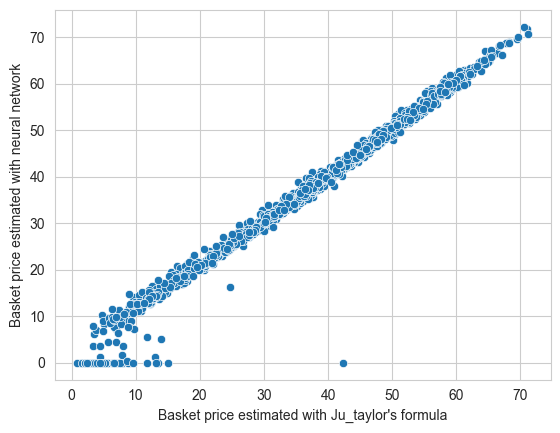

In [12]:
sns.scatterplot(x='Basket_Price', y='ANN_Price', data=test_prices)
_=plt.xlabel("Basket price estimated with Ju_taylor's formula")
_=plt.ylabel("Basket price estimated with neural network")
plt.savefig('figures/nn-levy_test-data.png')

Note that both outliers (top rows below) had the maximum possible time to maturity (15) and a fairly high price-to-strike ratio. 

In [13]:
test_prices.sort_values('Model_Error', ascending=False)

,Price_1,Price_2,Price_3,Price_4,Weight_1,Weight_2,Weight_3,Weight_4,Strike,Maturity,Volatility,Rate,Basket_Price,ANN_Price,Model_Error,Log_Error,wS/K
4547,82.525990,112.388302,110.301473,114.280201,0.131577,0.017197,0.125760,0.725466,148.580291,14,0.377771,0.0,42.383005,0.000000,42.383005,1.627192,0.737441
8815,77.603859,130.548696,115.339630,108.496708,0.265193,0.192796,0.424193,0.117818,116.520398,2,0.381709,0.0,15.097731,0.000000,15.097731,1.178912,0.922228
8120,102.342412,138.822470,104.885644,83.140430,0.105808,0.355728,0.278332,0.260132,133.906332,2,0.423615,0.0,13.490229,0.000000,13.490229,1.130019,0.829178
8680,70.169124,99.288717,91.916184,94.632884,0.128686,0.179251,0.306581,0.385482,120.887264,4,0.378115,0.0,13.170371,0.000000,13.170371,1.119598,0.756791
8523,100.898250,92.495557,82.329347,116.720737,0.101808,0.828285,0.034586,0.035321,130.042258,3,0.393825,0.0,13.006582,1.139907,11.866676,1.074329,0.721728
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8828,87.028848,116.268295,94.255627,89.607477,0.304538,0.261085,0.161292,0.273085,53.829021,13,0.376601,0.0,56.062407,56.058727,0.003680,-2.434183,1.793319
7832,105.239278,100.769360,106.406174,100.954099,0.289438,0.130630,0.279991,0.299941,115.783771,6,0.386241,0.0,26.515642,26.518856,0.003214,-2.492919,0.895607
622,101.945131,127.919712,94.906050,100.208510,0.435341,0.022848,0.237394,0.304418,65.724825,14,0.376022,0.0,55.554684,55.552441,0.002243,-2.649134,1.526651
9523,116.909142,100.055727,110.346356,117.980978,0.193032,0.291239,0.301254,0.214476,74.995772,13,0.375994,0.0,57.687463,57.688770,0.001307,-2.883699,1.470131


#### 3. Compare a subset of the test cases to a Monte Carlo solver

In [14]:
subset = test_prices.iloc[:100]

In [15]:
mc_prices = []
for i in range(subset.shape[0]):
    opt = BasketOption(
        subset.iloc[i,4:8].to_numpy(),
        subset.iloc[i,:4].to_numpy(),
        subset.iloc[i].Volatility,
        corr,
        subset.iloc[i].Strike,
        subset.iloc[i].Maturity,
        subset.iloc[i].Rate
    )

    mc_prices.append(opt.get_mc_price(n_paths=2000000))

subset['MC_Price'] = mc_prices

C:\Users\Vlada\AppData\Local\Temp\ipykernel_28840\178142683.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['MC_Price'] = mc_prices


In [16]:
subset['ANN-MC_Error'] = abs(subset['ANN_Price'] - subset['MC_Price'])

C:\Users\Vlada\AppData\Local\Temp\ipykernel_28840\2212790973.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['ANN-MC_Error'] = abs(subset['ANN_Price'] - subset['MC_Price'])


From the description below, **mean absolute error (MAE) of the network is 0.85** with range [2.15e-2, 2.06] (relative to Monte Carlo).

In [17]:
subset.describe()

,Price_1,Price_2,Price_3,Price_4,Weight_1,Weight_2,Weight_3,Weight_4,Strike,Maturity,Volatility,Rate,Basket_Price,ANN_Price,Model_Error,Log_Error,wS/K,MC_Price,ANN-MC_Error
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,99.038408,99.378233,100.060430,99.930234,0.224519,0.255158,0.241083,0.279241,95.585104,8.780000,0.401733,0.0,38.470353,39.109653,0.797839,-0.348923,1.131680,39.150601,0.920624
std,10.590967,9.567476,9.435509,9.747892,0.123810,0.122364,0.127059,0.125431,26.847684,4.375275,0.014479,0.0,13.457003,13.056393,0.841972,0.617468,0.339782,13.649655,0.792264
min,71.663425,77.182476,75.751637,78.405584,0.002799,0.008791,0.012470,0.043153,52.556779,1.000000,0.375659,0.0,5.470599,9.695277,0.000056,-4.254026,0.632013,5.511948,0.037229
25%,92.093974,92.603908,94.656050,94.497170,0.139158,0.185623,0.155137,0.214058,71.898710,5.000000,0.391255,0.0,27.471674,27.888585,0.275979,-0.559125,0.843040,28.279193,0.353631
50%,99.845334,100.583688,99.791063,99.664907,0.231841,0.255067,0.244201,0.278182,94.309480,9.000000,0.402708,0.0,39.059031,39.768003,0.527932,-0.277632,1.046450,39.400432,0.737440
75%,106.248417,104.563239,107.014474,104.460689,0.301047,0.332805,0.323302,0.354487,114.360091,12.000000,0.414521,0.0,48.780818,49.211641,0.941528,-0.026196,1.409298,49.843957,1.096789
max,122.142420,120.272487,119.594113,135.715792,0.575822,0.623859,0.582195,0.808793,147.295476,15.000000,0.424878,0.0,60.194236,60.275871,4.224678,0.625794,1.930046,60.536405,4.183330


Visual inspection of the pairplot suggests a relationship between strike price and absolute error of neural network relative to Monte Carlo (MC) estimates.

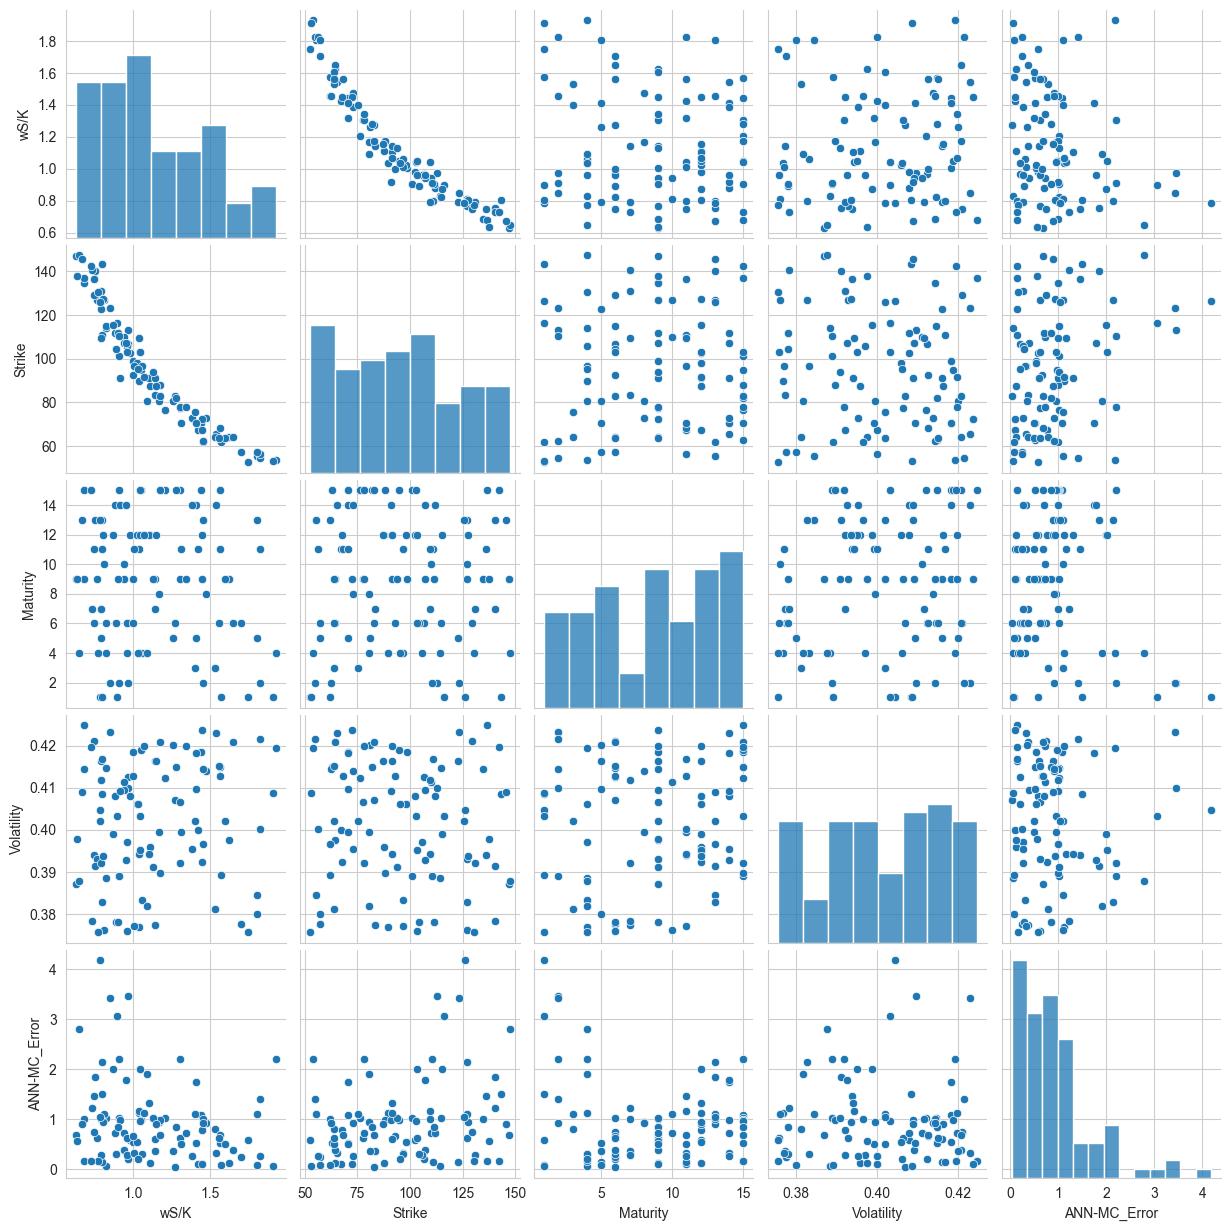

In [18]:
sns.pairplot(subset[['wS/K','Strike','Maturity','Volatility','ANN-MC_Error']])

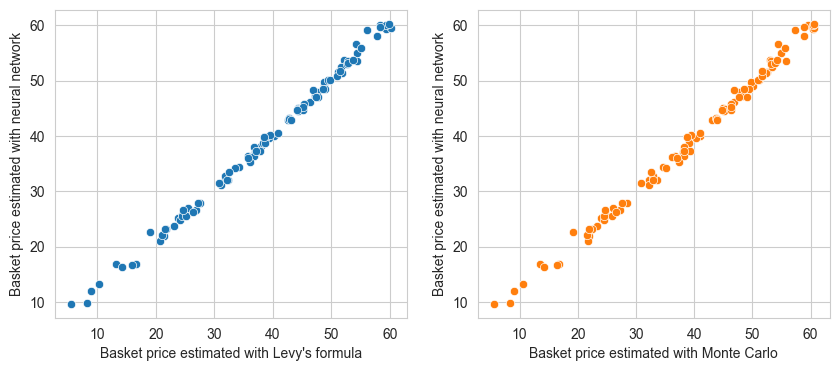

In [19]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
sns.scatterplot(x='Basket_Price', y='ANN_Price', data=subset, ax=ax[0])
sns.scatterplot(x='MC_Price', y='ANN_Price', data=subset, ax=ax[1], color='C1')

_=ax[0].set_xlabel("Basket price estimated with Levy's formula")
_=ax[0].set_ylabel("Basket price estimated with neural network")
_=ax[1].set_xlabel("Basket price estimated with Monte Carlo")
_=ax[1].set_ylabel("Basket price estimated with neural network")
plt.savefig('figures/nn-mc_prices.png')